In [ ]:
# Análisis de Clasificación - Industria Azucarera
# Proyecto: Predicción y Clasificación en la Industria Azucarera ICESI
# 
# Objetivo: Crear categorías de clasificación para variables TCH y %Sac.Caña
# en niveles de desempeño: alto, medio y bajo
# 
# Técnicas de Clasificación:
# 1. Regresión Logística
# 2. Random Forest
# 3. K-means

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Librerías importadas correctamente")
print("Técnicas de clasificación: Regresión Logística, Random Forest, K-means")
print("="*50)


Librerías importadas correctamente
Técnicas de clasificación: Regresión Logística, Random Forest, K-means


In [29]:
# 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ===========================================

# Cargar el dataset
df = pd.read_excel('../data/raw/BD_IPSA_1940.xlsx')

print("INFORMACIÓN GENERAL DEL DATASET")
print("="*50)
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de registros: {df.shape[0]}")
print(f"Número de variables: {df.shape[1]}")
print("\nPrimeras 5 filas del dataset:")
print(df.head())

print("\nInformación de columnas:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())


INFORMACIÓN GENERAL DEL DATASET
Dimensiones del dataset: (2187, 21)
Número de registros: 2187
Número de variables: 21

Primeras 5 filas del dataset:
   Unnamed: 0          NOME    FAZ TAL         tipocorte   variedad madurada  \
0          11  AMAIME SILCA  81291  40  Mecanizado Verde  CC01-1940       SI   
1          12  AMAIME SILCA  81291  41  Mecanizado Verde  CC01-1940       SI   
2          13  AMAIME SILCA  81291  41  Mecanizado Verde  CC01-1940       SI   
3          15  AMAIME SILCA  81291  43  Mecanizado Verde  CC01-1940       SI   
4          16  AMAIME SILCA  81291  43  Mecanizado Verde  CC01-1940       SI   

                             producto  dosismad  semsmad  ...  cortes    me  \
0  BONUS 250 EC REGULADOR FISIOLÓGICO       0.8      8.3  ...       4  12.7   
1  BONUS 250 EC REGULADOR FISIOLÓGICO       0.8      6.3  ...       2   7.8   
2  BONUS 250 EC REGULADOR FISIOLÓGICO       0.6      7.9  ...       3   8.8   
3  BONUS 250 EC REGULADOR FISIOLÓGICO       0.8      6

In [30]:
# 2. ANÁLISIS ESPECÍFICO DE VARIABLES OBJETIVO
# =============================================

# Verificar si las columnas TCH y %Sac.Caña existen
print("ANÁLISIS DE VARIABLES OBJETIVO")
print("="*50)
print("Nombres de columnas disponibles:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

# Buscar columnas relacionadas con TCH y Sacarosa
tch_columns = [col for col in df.columns if 'TCH' in col.upper() or 'TONELADA' in col.upper()]
sacarosa_columns = [col for col in df.columns if 'SAC' in col.upper() or 'SACAROSA' in col.upper() or '%' in col]

print(f"\nColumnas relacionadas con TCH: {tch_columns}")
print(f"Columnas relacionadas con Sacarosa: {sacarosa_columns}")

# Mostrar valores únicos para entender mejor los datos
print("\nValores únicos en las primeras columnas:")
for col in df.columns[:10]:
    print(f"{col}: {df[col].nunique()} valores únicos")


ANÁLISIS DE VARIABLES OBJETIVO
Nombres de columnas disponibles:
1. Unnamed: 0
2. NOME
3. FAZ
4. TAL
5. tipocorte
6. variedad
7. madurada
8. producto
9. dosismad
10. semsmad
11. edad
12. cortes
13. me
14. vejez
15. sacarosa
16. mes
17. periodo
18. TCH
19. lluvias
20. grupo_tenencia
21. pct_diatrea

Columnas relacionadas con TCH: ['TCH']
Columnas relacionadas con Sacarosa: ['sacarosa']

Valores únicos en las primeras columnas:
Unnamed: 0: 2187 valores únicos
NOME: 285 valores únicos
FAZ: 285 valores únicos
TAL: 273 valores únicos
tipocorte: 1 valores únicos
variedad: 1 valores únicos
madurada: 1 valores únicos
producto: 1 valores únicos
dosismad: 18 valores únicos
semsmad: 150 valores únicos


In [31]:
# 3. IDENTIFICACIÓN Y SELECCIÓN DE VARIABLES OBJETIVO
# ===================================================

# Función para encontrar la mejor columna basada en patrones
def find_best_column(df, keywords):
    """
    Encuentra la mejor columna basada en palabras clave
    """
    matches = []
    for col in df.columns:
        col_upper = col.upper()
        for keyword in keywords:
            if keyword.upper() in col_upper:
                matches.append(col)
                break
    return matches

# Buscar columnas para TCH (Toneladas de Caña por Hectárea)
tch_keywords = ['TCH', 'TONELADA', 'CAÑA', 'HECTAREA', 'RENDIMIENTO']
tch_candidates = find_best_column(df, tch_keywords)

# Buscar columnas para %Sac.Caña (Porcentaje de Sacarosa en Caña)
sacarosa_keywords = ['SAC', 'SACAROSA', '%', 'PORCENTAJE', 'POL']
sacarosa_candidates = find_best_column(df, sacarosa_keywords)

print("CANDIDATOS PARA VARIABLES OBJETIVO")
print("="*50)
print(f"Candidatos para TCH: {tch_candidates}")
print(f"Candidatos para %Sac.Caña: {sacarosa_candidates}")

# Analizar los candidatos más prometedores
if tch_candidates:
    print(f"\nAnálisis de candidatos TCH:")
    for col in tch_candidates[:3]:  # Analizar los primeros 3 candidatos
        print(f"\nColumna: {col}")
        print(f"Tipo: {df[col].dtype}")
        print(f"Valores únicos: {df[col].nunique()}")
        print(f"Valores nulos: {df[col].isnull().sum()}")
        if df[col].dtype in ['int64', 'float64']:
            print(f"Rango: {df[col].min():.2f} - {df[col].max():.2f}")
            print(f"Media: {df[col].mean():.2f}")

if sacarosa_candidates:
    print(f"\nAnálisis de candidatos %Sac.Caña:")
    for col in sacarosa_candidates[:3]:  # Analizar los primeros 3 candidatos
        print(f"\nColumna: {col}")
        print(f"Tipo: {df[col].dtype}")
        print(f"Valores únicos: {df[col].nunique()}")
        print(f"Valores nulos: {df[col].isnull().sum()}")
        if df[col].dtype in ['int64', 'float64']:
            print(f"Rango: {df[col].min():.2f} - {df[col].max():.2f}")
            print(f"Media: {df[col].mean():.2f}")


CANDIDATOS PARA VARIABLES OBJETIVO
Candidatos para TCH: ['TCH']
Candidatos para %Sac.Caña: ['sacarosa']

Análisis de candidatos TCH:

Columna: TCH
Tipo: int64
Valores únicos: 153
Valores nulos: 0
Rango: 6.00 - 249.00
Media: 142.39

Análisis de candidatos %Sac.Caña:

Columna: sacarosa
Tipo: float64
Valores únicos: 62
Valores nulos: 0
Rango: 9.20 - 16.00
Media: 12.78


In [32]:
# 4. SELECCIÓN FINAL DE VARIABLES OBJETIVO
# ========================================

# Basado en el análisis anterior, usar las columnas correctas identificadas
# TCH y sacarosa son las columnas correctas según el análisis previo

print("SELECCIÓN CORRECTA DE VARIABLES OBJETIVO")
print("="*50)

# Usar las columnas correctas identificadas en el análisis anterior
tch_col = 'TCH'  # Columna TCH correcta
sacarosa_col = 'sacarosa'  # Columna sacarosa correcta

print(f"VARIABLES SELECCIONADAS:")
print(f"TCH: {tch_col}")
print(f"%Sac.Caña: {sacarosa_col}")

# Verificar que las columnas existen
if tch_col in df.columns and sacarosa_col in df.columns:
    # Crear un dataset limpio con las variables objetivo correctas
    df_clean = df[[tch_col, sacarosa_col]].copy()
    
    # Eliminar filas con valores nulos
    df_clean = df_clean.dropna()
    
    print(f"\nDataset limpio:")
    print(f"Dimensiones: {df_clean.shape}")
    print(f"Valores nulos: {df_clean.isnull().sum().sum()}")
    
    # Renombrar columnas para mayor claridad
    df_clean.columns = ['TCH', 'Sacarosa_Porcentaje']
    
    print(f"\nEstadísticas descriptivas del dataset limpio:")
    print(df_clean.describe())
    
    # Verificar que los valores son razonables
    print(f"\nVERIFICACIÓN DE RANGOS:")
    print(f"TCH - Rango: {df_clean['TCH'].min():.2f} - {df_clean['TCH'].max():.2f}")
    print(f"TCH - Media: {df_clean['TCH'].mean():.2f}")
    print(f"Sacarosa - Rango: {df_clean['Sacarosa_Porcentaje'].min():.2f} - {df_clean['Sacarosa_Porcentaje'].max():.2f}")
    print(f"Sacarosa - Media: {df_clean['Sacarosa_Porcentaje'].mean():.2f}")
    
else:
    print("Error: Las columnas TCH y/o sacarosa no existen en el dataset")
    print("Columnas disponibles:", df.columns.tolist())


SELECCIÓN CORRECTA DE VARIABLES OBJETIVO
VARIABLES SELECCIONADAS:
TCH: TCH
%Sac.Caña: sacarosa

Dataset limpio:
Dimensiones: (2187, 2)
Valores nulos: 0

Estadísticas descriptivas del dataset limpio:
               TCH  Sacarosa_Porcentaje
count  2187.000000          2187.000000
mean    142.393233            12.777732
std      25.838029             0.854397
min       6.000000             9.200000
25%     126.000000            12.200000
50%     144.000000            12.800000
75%     159.000000            13.300000
max     249.000000            16.000000

VERIFICACIÓN DE RANGOS:
TCH - Rango: 6.00 - 249.00
TCH - Media: 142.39
Sacarosa - Rango: 9.20 - 16.00
Sacarosa - Media: 12.78


ANÁLISIS DE DISTRIBUCIÓN DE VARIABLES
VERIFICACIÓN DE DATOS CORRECTOS:
------------------------------
TCH - Rango esperado: 6.00 - 249.00 (Media: ~142)
Sacarosa - Rango esperado: 9.20 - 16.00 (Media: ~12.78)
TCH - Rango actual: 6.00 - 249.00 (Media: 142.39)
Sacarosa - Rango actual: 9.20 - 16.00 (Media: 12.78)

ESTADÍSTICAS DETALLADAS:
------------------------------

TCH:
  Media: 142.3932
  Mediana: 144.0000
  Desviación estándar: 25.8380
  Mínimo: 6.0000
  Máximo: 249.0000
  Rango: 243.0000
  Coeficiente de variación: 18.15%

Sacarosa_Porcentaje:
  Media: 12.7777
  Mediana: 12.8000
  Desviación estándar: 0.8544
  Mínimo: 9.2000
  Máximo: 16.0000
  Rango: 6.8000
  Coeficiente de variación: 6.69%

ANÁLISIS DE PERCENTILES:
------------------------------

TCH:
  P10: 110.0000
  P25: 126.0000
  P33: 132.3800
  P50: 144.0000
  P67: 154.0000
  P75: 159.0000
  P90: 174.0000

Sacarosa_Porcentaje:
  P10: 11.7000
  P25: 12.2000
  P33: 12.4000
  P50: 12.8000
  P67: 13.1000
  P75: 13.3000
  P90: 1

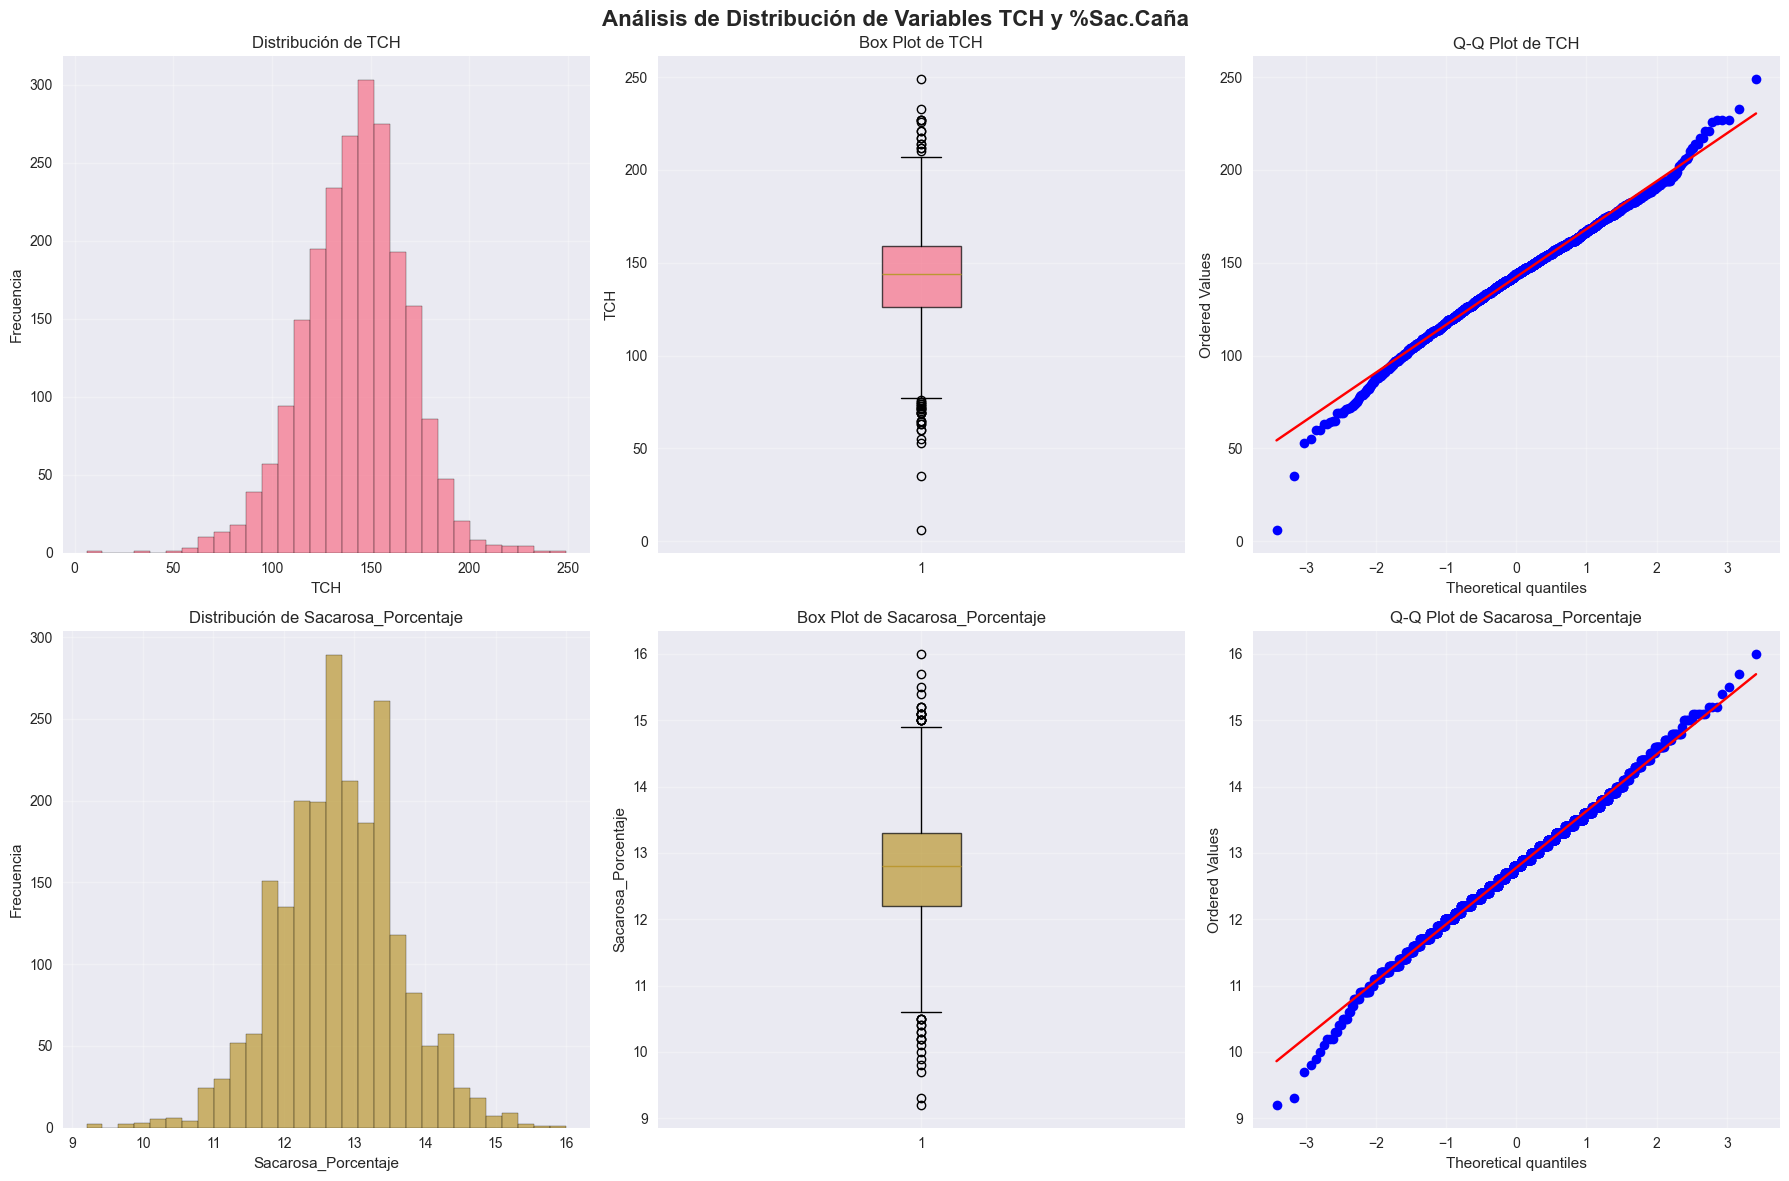


ANÁLISIS DE CORRELACIÓN:
------------------------------
                          TCH  Sacarosa_Porcentaje
TCH                  1.000000            -0.207086
Sacarosa_Porcentaje -0.207086             1.000000


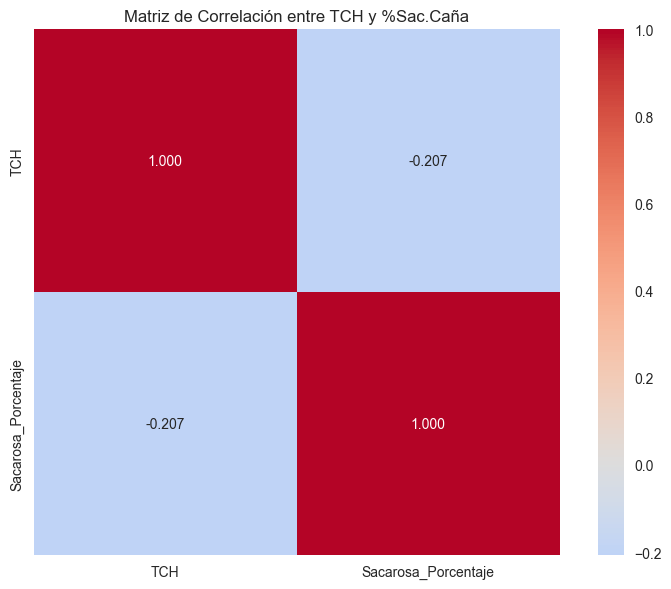

In [33]:
# 5. ANÁLISIS DE DISTRIBUCIÓN Y VISUALIZACIÓN DE VARIABLES
# ========================================================

# Análisis detallado de la distribución de las variables
print("ANÁLISIS DE DISTRIBUCIÓN DE VARIABLES")
print("="*50)

# Verificar que tenemos los datos correctos
print("VERIFICACIÓN DE DATOS CORRECTOS:")
print("-" * 30)
print(f"TCH - Rango esperado: 6.00 - 249.00 (Media: ~142)")
print(f"Sacarosa - Rango esperado: 9.20 - 16.00 (Media: ~12.78)")
print(f"TCH - Rango actual: {df_clean['TCH'].min():.2f} - {df_clean['TCH'].max():.2f} (Media: {df_clean['TCH'].mean():.2f})")
print(f"Sacarosa - Rango actual: {df_clean['Sacarosa_Porcentaje'].min():.2f} - {df_clean['Sacarosa_Porcentaje'].max():.2f} (Media: {df_clean['Sacarosa_Porcentaje'].mean():.2f})")

# Estadísticas detalladas
print("\nESTADÍSTICAS DETALLADAS:")
print("-" * 30)
for col in df_clean.columns:
    print(f"\n{col}:")
    print(f"  Media: {df_clean[col].mean():.4f}")
    print(f"  Mediana: {df_clean[col].median():.4f}")
    print(f"  Desviación estándar: {df_clean[col].std():.4f}")
    print(f"  Mínimo: {df_clean[col].min():.4f}")
    print(f"  Máximo: {df_clean[col].max():.4f}")
    print(f"  Rango: {df_clean[col].max() - df_clean[col].min():.4f}")
    print(f"  Coeficiente de variación: {(df_clean[col].std() / df_clean[col].mean() * 100):.2f}%")

# Análisis de percentiles para determinar umbrales
print(f"\nANÁLISIS DE PERCENTILES:")
print("-" * 30)
percentiles = [10, 25, 33, 50, 67, 75, 90]
for col in df_clean.columns:
    print(f"\n{col}:")
    for p in percentiles:
        value = np.percentile(df_clean[col], p)
        print(f"  P{p}: {value:.4f}")

# Crear visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Distribución de Variables TCH y %Sac.Caña', fontsize=16, fontweight='bold')

# Histogramas
for i, col in enumerate(df_clean.columns):
    axes[i, 0].hist(df_clean[col], bins=30, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i, 0].set_title(f'Distribución de {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frecuencia')
    axes[i, 0].grid(True, alpha=0.3)

# Box plots
for i, col in enumerate(df_clean.columns):
    axes[i, 1].boxplot(df_clean[col], patch_artist=True, 
                       boxprops=dict(facecolor=f'C{i}', alpha=0.7))
    axes[i, 1].set_title(f'Box Plot de {col}')
    axes[i, 1].set_ylabel(col)
    axes[i, 1].grid(True, alpha=0.3)

# Q-Q plots para verificar normalidad
from scipy import stats
for i, col in enumerate(df_clean.columns):
    stats.probplot(df_clean[col], dist="norm", plot=axes[i, 2])
    axes[i, 2].set_title(f'Q-Q Plot de {col}')
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de correlación
print(f"\nANÁLISIS DE CORRELACIÓN:")
print("-" * 30)
correlation = df_clean.corr()
print(correlation)

# Visualización de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Matriz de Correlación entre TCH y %Sac.Caña')
plt.tight_layout()
plt.show()


In [34]:
# 6. CREACIÓN DE CATEGORÍAS DE CLASIFICACIÓN
# ===========================================

print("CREACIÓN DE CATEGORÍAS DE CLASIFICACIÓN")
print("="*50)

# Verificar que los datos son correctos antes de proceder
print("VERIFICACIÓN PREVIA:")
print("-" * 20)
print(f"TCH - Rango: {df_clean['TCH'].min():.2f} - {df_clean['TCH'].max():.2f}")
print(f"Sacarosa - Rango: {df_clean['Sacarosa_Porcentaje'].min():.2f} - {df_clean['Sacarosa_Porcentaje'].max():.2f}")

# Método 1: Clasificación basada en percentiles (33% y 67%)
print("\nMÉTODO 1: CLASIFICACIÓN POR PERCENTILES")
print("-" * 40)

def create_percentile_categories(data, col_name):
    """
    Crea categorías basadas en percentiles 33 y 67
    """
    p33 = np.percentile(data, 33)
    p67 = np.percentile(data, 67)
    
    categories = []
    for value in data:
        if value <= p33:
            categories.append('Bajo')
        elif value <= p67:
            categories.append('Medio')
        else:
            categories.append('Alto')
    
    return categories, p33, p67

# Crear categorías para TCH
tch_categories, tch_p33, tch_p67 = create_percentile_categories(df_clean['TCH'], 'TCH')
df_clean['TCH_Categoria'] = tch_categories

# Crear categorías para Sacarosa
sac_categories, sac_p33, sac_p67 = create_percentile_categories(df_clean['Sacarosa_Porcentaje'], 'Sacarosa')
df_clean['Sacarosa_Categoria'] = sac_categories

print(f"Umbrales TCH:")
print(f"  Bajo: ≤ {tch_p33:.4f} toneladas/hectárea")
print(f"  Medio: {tch_p33:.4f} < x ≤ {tch_p67:.4f} toneladas/hectárea")
print(f"  Alto: > {tch_p67:.4f} toneladas/hectárea")

print(f"\nUmbrales %Sac.Caña:")
print(f"  Bajo: ≤ {sac_p33:.4f}%")
print(f"  Medio: {sac_p33:.4f}% < x ≤ {sac_p67:.4f}%")
print(f"  Alto: > {sac_p67:.4f}%")

# Distribución de categorías
print(f"\nDISTRIBUCIÓN DE CATEGORÍAS:")
print("-" * 30)
print("TCH:")
tch_dist = df_clean['TCH_Categoria'].value_counts()
for cat in ['Bajo', 'Medio', 'Alto']:
    count = tch_dist.get(cat, 0)
    percentage = (count / len(df_clean)) * 100
    print(f"  {cat}: {count} registros ({percentage:.1f}%)")

print("\nSacarosa:")
sac_dist = df_clean['Sacarosa_Categoria'].value_counts()
for cat in ['Bajo', 'Medio', 'Alto']:
    count = sac_dist.get(cat, 0)
    percentage = (count / len(df_clean)) * 100
    print(f"  {cat}: {count} registros ({percentage:.1f}%)")

# Crear categoría combinada de desempeño
def create_combined_category(tch_cat, sac_cat):
    """
    Crea una categoría combinada basada en TCH y Sacarosa
    """
    if tch_cat == 'Alto' and sac_cat == 'Alto':
        return 'Excelente'
    elif tch_cat == 'Alto' or sac_cat == 'Alto':
        return 'Bueno'
    elif tch_cat == 'Medio' and sac_cat == 'Medio':
        return 'Regular'
    elif tch_cat == 'Bajo' and sac_cat == 'Bajo':
        return 'Deficiente'
    else:
        return 'Mixto'

df_clean['Desempeño_Combinado'] = df_clean.apply(
    lambda row: create_combined_category(row['TCH_Categoria'], row['Sacarosa_Categoria']), 
    axis=1
)

print(f"\nCATEGORÍA COMBINADA DE DESEMPEÑO:")
print("-" * 30)
combined_dist = df_clean['Desempeño_Combinado'].value_counts()
for cat in combined_dist.index:
    count = combined_dist[cat]
    percentage = (count / len(df_clean)) * 100
    print(f"  {cat}: {count} registros ({percentage:.1f}%)")


CREACIÓN DE CATEGORÍAS DE CLASIFICACIÓN
VERIFICACIÓN PREVIA:
--------------------
TCH - Rango: 6.00 - 249.00
Sacarosa - Rango: 9.20 - 16.00

MÉTODO 1: CLASIFICACIÓN POR PERCENTILES
----------------------------------------
Umbrales TCH:
  Bajo: ≤ 132.3800 toneladas/hectárea
  Medio: 132.3800 < x ≤ 154.0000 toneladas/hectárea
  Alto: > 154.0000 toneladas/hectárea

Umbrales %Sac.Caña:
  Bajo: ≤ 12.4000%
  Medio: 12.4000% < x ≤ 13.1000%
  Alto: > 13.1000%

DISTRIBUCIÓN DE CATEGORÍAS:
------------------------------
TCH:
  Bajo: 722 registros (33.0%)
  Medio: 762 registros (34.8%)
  Alto: 703 registros (32.1%)

Sacarosa:
  Bajo: 761 registros (34.8%)
  Medio: 710 registros (32.5%)
  Alto: 716 registros (32.7%)

CATEGORÍA COMBINADA DE DESEMPEÑO:
------------------------------
  Bueno: 1115 registros (51.0%)
  Mixto: 430 registros (19.7%)
  Regular: 266 registros (12.2%)
  Deficiente: 224 registros (10.2%)
  Excelente: 152 registros (7.0%)


CREANDO VISUALIZACIONES AVANZADAS


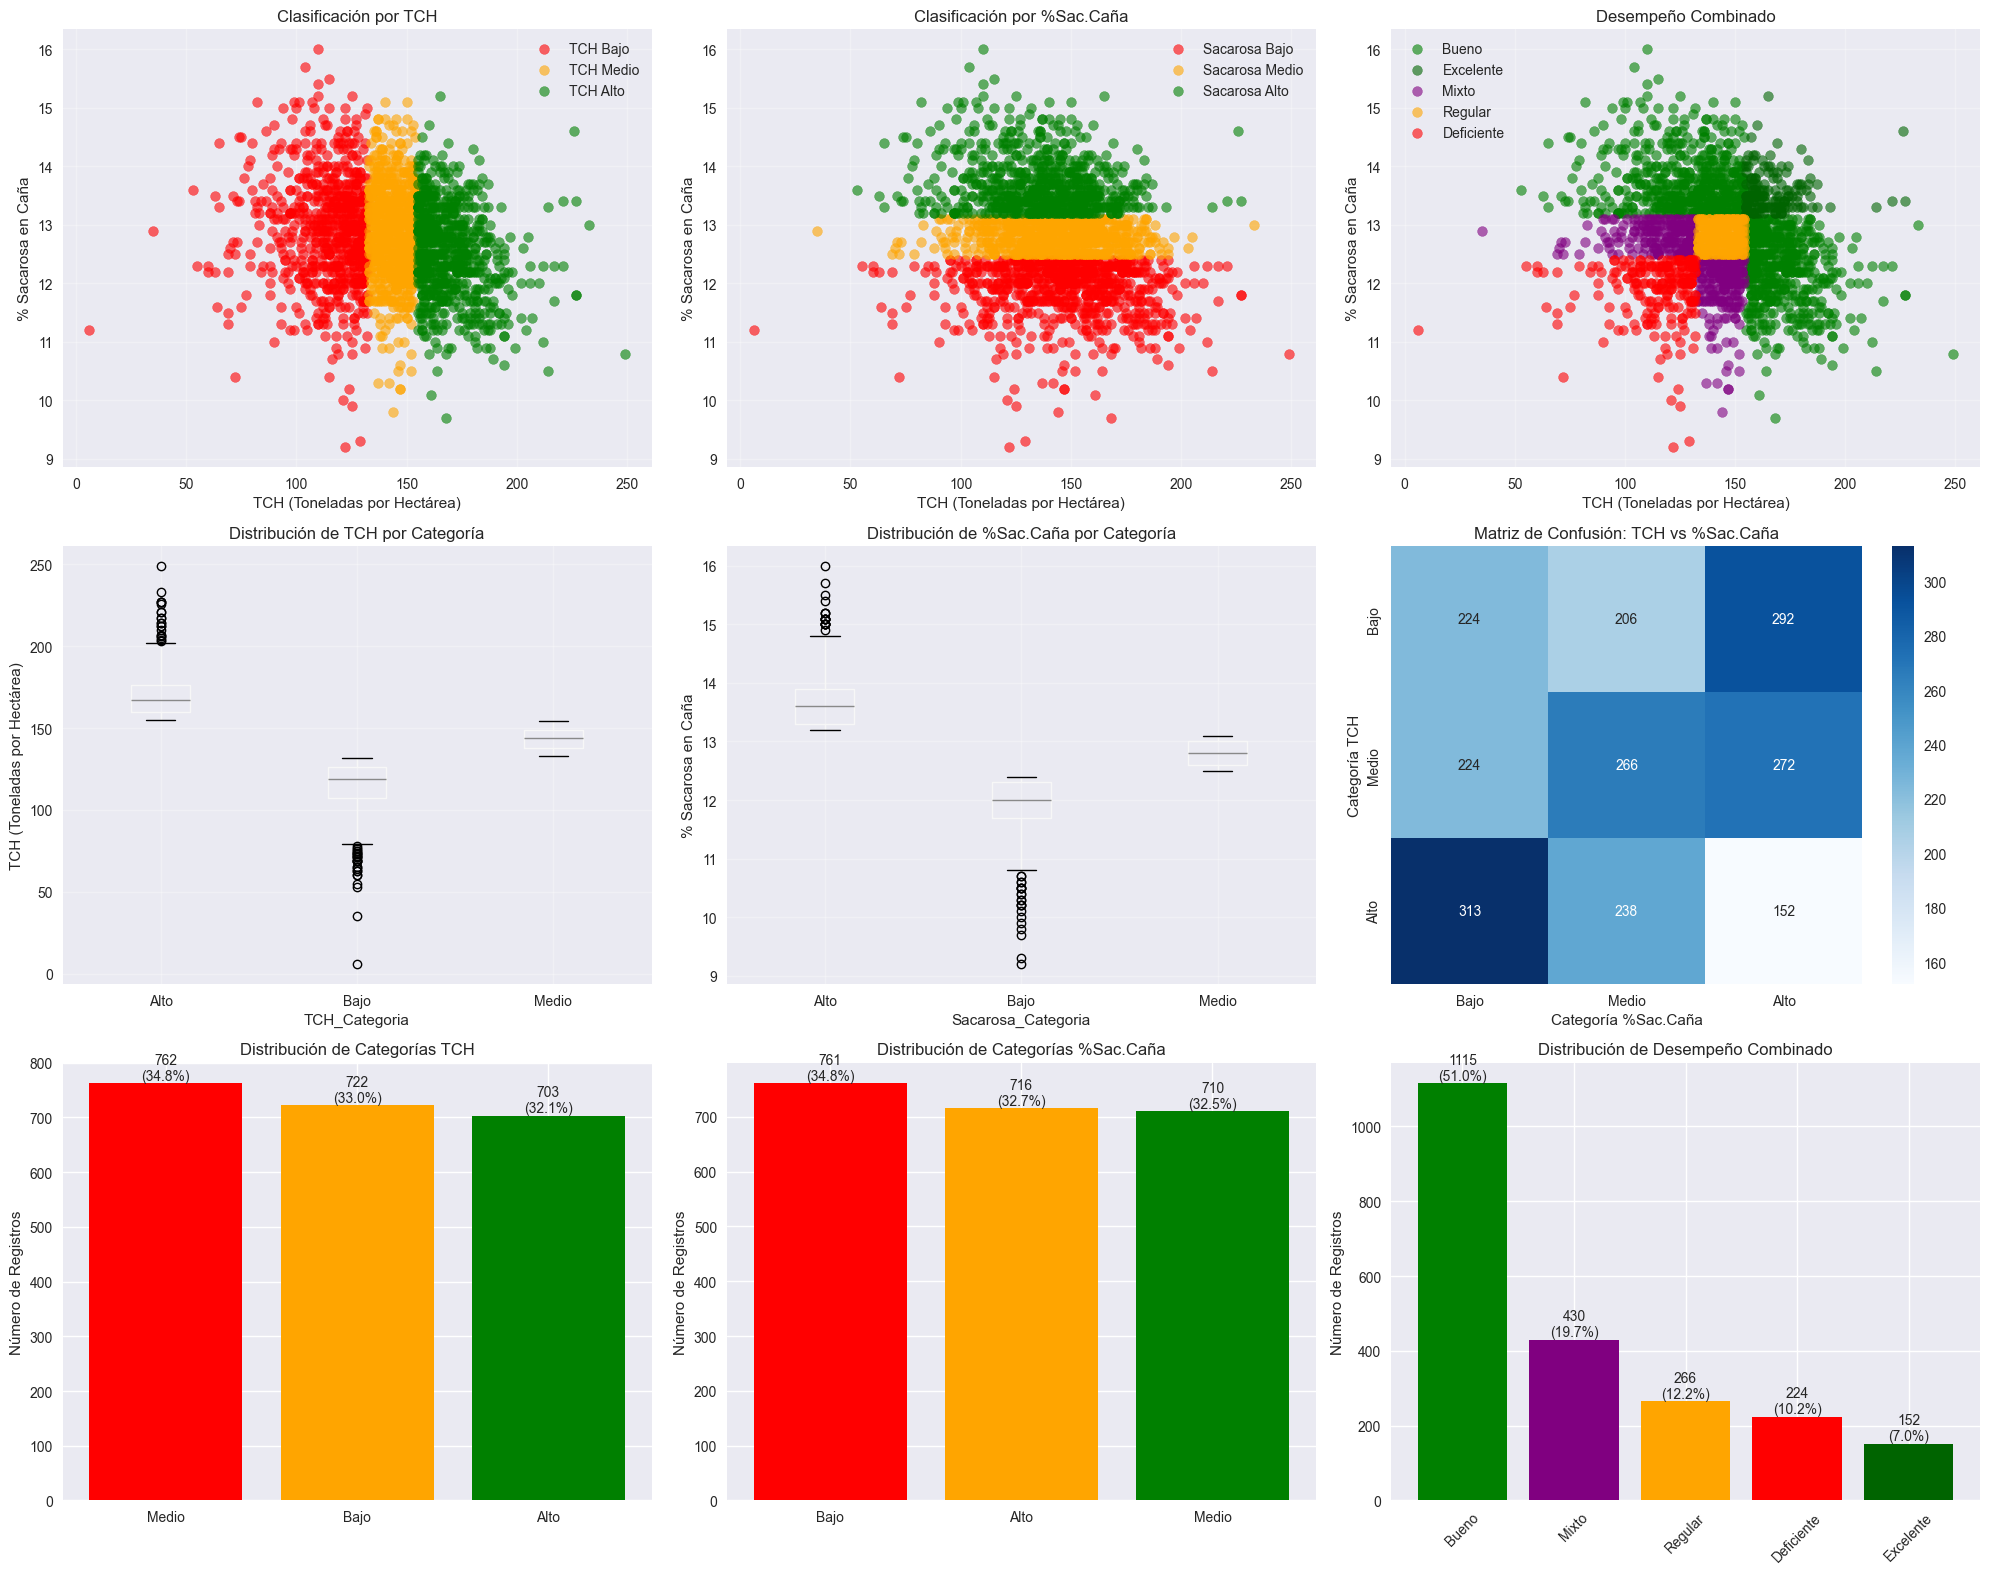


ANÁLISIS DE CORRELACIÓN ENTRE CATEGORÍAS:
----------------------------------------
Tabla de Contingencia:
Sacarosa_Categoria  Alto  Bajo  Medio
TCH_Categoria                        
Alto                 152   313    238
Bajo                 292   224    206
Medio                272   224    266

Prueba de Chi-cuadrado:
  Chi-cuadrado: 75.3762
  p-valor: 0.0000
  Grados de libertad: 4
  Resultado: Existe asociación significativa entre las categorías (p < 0.05)


In [35]:
# 7. VISUALIZACIONES AVANZADAS DE CLASIFICACIÓN
# =============================================

print("CREANDO VISUALIZACIONES AVANZADAS")
print("="*50)

# Crear figura con múltiples subplots
fig = plt.figure(figsize=(20, 16))

# 1. Scatter plot con categorías
ax1 = plt.subplot(3, 3, 1)
colors = {'Bajo': 'red', 'Medio': 'orange', 'Alto': 'green'}
for category in ['Bajo', 'Medio', 'Alto']:
    mask = df_clean['TCH_Categoria'] == category
    plt.scatter(df_clean.loc[mask, 'TCH'], df_clean.loc[mask, 'Sacarosa_Porcentaje'], 
               c=colors[category], label=f'TCH {category}', alpha=0.6, s=50)
plt.xlabel('TCH (Toneladas por Hectárea)')
plt.ylabel('% Sacarosa en Caña')
plt.title('Clasificación por TCH')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Scatter plot por categorías de Sacarosa
ax2 = plt.subplot(3, 3, 2)
for category in ['Bajo', 'Medio', 'Alto']:
    mask = df_clean['Sacarosa_Categoria'] == category
    plt.scatter(df_clean.loc[mask, 'TCH'], df_clean.loc[mask, 'Sacarosa_Porcentaje'], 
               c=colors[category], label=f'Sacarosa {category}', alpha=0.6, s=50)
plt.xlabel('TCH (Toneladas por Hectárea)')
plt.ylabel('% Sacarosa en Caña')
plt.title('Clasificación por %Sac.Caña')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Scatter plot por desempeño combinado
ax3 = plt.subplot(3, 3, 3)
combined_colors = {'Excelente': 'darkgreen', 'Bueno': 'green', 'Regular': 'orange', 
                   'Deficiente': 'red', 'Mixto': 'purple'}
for category in df_clean['Desempeño_Combinado'].unique():
    mask = df_clean['Desempeño_Combinado'] == category
    plt.scatter(df_clean.loc[mask, 'TCH'], df_clean.loc[mask, 'Sacarosa_Porcentaje'], 
               c=combined_colors[category], label=category, alpha=0.6, s=50)
plt.xlabel('TCH (Toneladas por Hectárea)')
plt.ylabel('% Sacarosa en Caña')
plt.title('Desempeño Combinado')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Distribución de TCH por categorías
ax4 = plt.subplot(3, 3, 4)
df_clean.boxplot(column='TCH', by='TCH_Categoria', ax=ax4)
plt.title('Distribución de TCH por Categoría')
plt.suptitle('')  # Eliminar título automático
plt.ylabel('TCH (Toneladas por Hectárea)')
plt.grid(True, alpha=0.3)

# 5. Distribución de Sacarosa por categorías
ax5 = plt.subplot(3, 3, 5)
df_clean.boxplot(column='Sacarosa_Porcentaje', by='Sacarosa_Categoria', ax=ax5)
plt.title('Distribución de %Sac.Caña por Categoría')
plt.suptitle('')  # Eliminar título automático
plt.ylabel('% Sacarosa en Caña')
plt.grid(True, alpha=0.3)

# 6. Matriz de confusión entre categorías
ax6 = plt.subplot(3, 3, 6)
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Crear matriz de confusión entre TCH y Sacarosa
tch_encoded = pd.Categorical(df_clean['TCH_Categoria'], categories=['Bajo', 'Medio', 'Alto']).codes
sac_encoded = pd.Categorical(df_clean['Sacarosa_Categoria'], categories=['Bajo', 'Medio', 'Alto']).codes

cm = confusion_matrix(tch_encoded, sac_encoded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bajo', 'Medio', 'Alto'],
            yticklabels=['Bajo', 'Medio', 'Alto'], ax=ax6)
plt.title('Matriz de Confusión: TCH vs %Sac.Caña')
plt.xlabel('Categoría %Sac.Caña')
plt.ylabel('Categoría TCH')

# 7. Gráfico de barras - Distribución de categorías TCH
ax7 = plt.subplot(3, 3, 7)
tch_counts = df_clean['TCH_Categoria'].value_counts()
bars = ax7.bar(tch_counts.index, tch_counts.values, color=['red', 'orange', 'green'])
plt.title('Distribución de Categorías TCH')
plt.ylabel('Número de Registros')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}\n({height/len(df_clean)*100:.1f}%)',
             ha='center', va='bottom')

# 8. Gráfico de barras - Distribución de categorías Sacarosa
ax8 = plt.subplot(3, 3, 8)
sac_counts = df_clean['Sacarosa_Categoria'].value_counts()
bars = ax8.bar(sac_counts.index, sac_counts.values, color=['red', 'orange', 'green'])
plt.title('Distribución de Categorías %Sac.Caña')
plt.ylabel('Número de Registros')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}\n({height/len(df_clean)*100:.1f}%)',
             ha='center', va='bottom')

# 9. Gráfico de barras - Desempeño combinado
ax9 = plt.subplot(3, 3, 9)
combined_counts = df_clean['Desempeño_Combinado'].value_counts()
colors_combined = [combined_colors[cat] for cat in combined_counts.index]
bars = ax9.bar(combined_counts.index, combined_counts.values, color=colors_combined)
plt.title('Distribución de Desempeño Combinado')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}\n({height/len(df_clean)*100:.1f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Análisis de correlación entre categorías
print("\nANÁLISIS DE CORRELACIÓN ENTRE CATEGORÍAS:")
print("-" * 40)
from scipy.stats import chi2_contingency

# Tabla de contingencia
contingency_table = pd.crosstab(df_clean['TCH_Categoria'], df_clean['Sacarosa_Categoria'])
print("Tabla de Contingencia:")
print(contingency_table)

# Prueba de chi-cuadrado
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nPrueba de Chi-cuadrado:")
print(f"  Chi-cuadrado: {chi2:.4f}")
print(f"  p-valor: {p_value:.4f}")
print(f"  Grados de libertad: {dof}")

if p_value < 0.05:
    print("  Resultado: Existe asociación significativa entre las categorías (p < 0.05)")
else:
    print("  Resultado: No existe asociación significativa entre las categorías (p ≥ 0.05)")


In [ ]:
# 8. IMPLEMENTACIÓN DE TÉCNICAS DE CLASIFICACIÓN SELECCIONADAS
# ============================================================

print("IMPLEMENTACIÓN DE TÉCNICAS DE CLASIFICACIÓN")
print("="*50)
print("Técnicas implementadas:")
print("1. Regresión Logística")
print("2. Random Forest")
print("3. K-means")

# Preparar datos para clasificación
X = df_clean[['TCH', 'Sacarosa_Porcentaje']].values
y_tch = df_clean['TCH_Categoria'].values
y_sac = df_clean['Sacarosa_Categoria'].values
y_combined = df_clean['Desempeño_Combinado'].values

# Codificar las etiquetas
from sklearn.preprocessing import LabelEncoder
le_tch = LabelEncoder()
le_sac = LabelEncoder()
le_combined = LabelEncoder()

y_tch_encoded = le_tch.fit_transform(y_tch)
y_sac_encoded = le_sac.fit_transform(y_sac)
y_combined_encoded = le_combined.fit_transform(y_combined)

print("\nDatos preparados para clasificación:")
print(f"  Características (X): {X.shape}")
print(f"  Etiquetas TCH: {len(np.unique(y_tch_encoded))} clases")
print(f"  Etiquetas Sacarosa: {len(np.unique(y_sac_encoded))} clases")
print(f"  Etiquetas Combinadas: {len(np.unique(y_combined_encoded))} clases")

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_tch_train, y_tch_test = train_test_split(
    X, y_tch_encoded, test_size=0.3, random_state=42, stratify=y_tch_encoded
)

X_train_sac, X_test_sac, y_sac_train, y_sac_test = train_test_split(
    X, y_sac_encoded, test_size=0.3, random_state=42, stratify=y_sac_encoded
)

X_train_comb, X_test_comb, y_comb_train, y_comb_test = train_test_split(
    X, y_combined_encoded, test_size=0.3, random_state=42, stratify=y_combined_encoded
)

# Estandarizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_sac_scaled = scaler.fit_transform(X_train_sac)
X_test_sac_scaled = scaler.transform(X_test_sac)

X_train_comb_scaled = scaler.fit_transform(X_train_comb)
X_test_comb_scaled = scaler.transform(X_test_comb)

print(f"\nDatos divididos:")
print(f"  Entrenamiento: {X_train.shape[0]} muestras")
print(f"  Prueba: {X_test.shape[0]} muestras")

# Definir modelos de clasificación (solo las técnicas solicitadas)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Función para evaluar modelos de clasificación supervisada
def evaluate_supervised_model(model, X_train, X_test, y_train, y_test, model_name, target_name):
    """
    Evalúa un modelo de clasificación supervisada y retorna métricas
    """
    # Entrenar modelo
    model.fit(X_train, y_train)
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{model_name} - {target_name}:")
    print(f"  Precisión: {accuracy:.4f}")
    
    # Reporte de clasificación
    target_names = le_tch.classes_ if 'TCH' in target_name else le_sac.classes_ if 'Sacarosa' in target_name else le_combined.classes_
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    return {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred,
        'report': report
    }

# Función para evaluar K-means
def evaluate_kmeans(X, y_true, n_clusters, target_name):
    """
    Evalúa K-means y retorna métricas
    """
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)
    
    # Calcular silhouette score
    silhouette = silhouette_score(X, y_pred)
    
    print(f"\nK-means - {target_name}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Número de clusters: {n_clusters}")
    
    return {
        'model': kmeans,
        'silhouette_score': silhouette,
        'predictions': y_pred,
        'n_clusters': n_clusters
    }

# Evaluar modelos supervisados para TCH
print("\n" + "="*60)
print("EVALUACIÓN DE MODELOS SUPERVISADOS PARA CLASIFICACIÓN TCH")
print("="*60)

results_tch = {}
for name, model in models.items():
    results_tch[name] = evaluate_supervised_model(
        model, X_train_scaled, X_test_scaled, 
        y_tch_train, y_tch_test, name, "TCH"
    )

# Evaluar K-means para TCH
print("\n" + "="*60)
print("EVALUACIÓN DE K-MEANS PARA TCH")
print("="*60)

kmeans_tch = evaluate_kmeans(X, y_tch_encoded, n_clusters=3, target_name="TCH")

# Evaluar modelos supervisados para Sacarosa
print("\n" + "="*60)
print("EVALUACIÓN DE MODELOS SUPERVISADOS PARA CLASIFICACIÓN SACAROSA")
print("="*60)

results_sac = {}
for name, model in models.items():
    results_sac[name] = evaluate_supervised_model(
        model, X_train_sac_scaled, X_test_sac_scaled, 
        y_sac_train, y_sac_test, name, "Sacarosa"
    )

# Evaluar K-means para Sacarosa
print("\n" + "="*60)
print("EVALUACIÓN DE K-MEANS PARA SACAROSA")
print("="*60)

kmeans_sac = evaluate_kmeans(X, y_sac_encoded, n_clusters=3, target_name="Sacarosa")

# Evaluar modelos supervisados para Desempeño Combinado
print("\n" + "="*60)
print("EVALUACIÓN DE MODELOS SUPERVISADOS PARA DESEMPEÑO COMBINADO")
print("="*60)

results_comb = {}
for name, model in models.items():
    results_comb[name] = evaluate_supervised_model(
        model, X_train_comb_scaled, X_test_comb_scaled, 
        y_comb_train, y_comb_test, name, "Desempeño Combinado"
    )

# Evaluar K-means para Desempeño Combinado
print("\n" + "="*60)
print("EVALUACIÓN DE K-MEANS PARA DESEMPEÑO COMBINADO")
print("="*60)

kmeans_comb = evaluate_kmeans(X, y_combined_encoded, n_clusters=5, target_name="Desempeño Combinado")

# Resumen de resultados
print("\n" + "="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)

print("\nPrecisión por modelo y objetivo (Modelos Supervisados):")
print("-" * 60)
for target, results in [("TCH", results_tch), ("Sacarosa", results_sac), ("Combinado", results_comb)]:
    print(f"\n{target}:")
    for model_name, result in results.items():
        print(f"  {model_name}: {result['accuracy']:.4f}")

print("\nSilhouette Score por objetivo (K-means):")
print("-" * 40)
print(f"TCH: {kmeans_tch['silhouette_score']:.4f}")
print(f"Sacarosa: {kmeans_sac['silhouette_score']:.4f}")
print(f"Desempeño Combinado: {kmeans_comb['silhouette_score']:.4f}")

# Identificar el mejor modelo supervisado para cada objetivo
best_models = {}
for target, results in [("TCH", results_tch), ("Sacarosa", results_sac), ("Combinado", results_comb)]:
    best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_models[target] = {
        'name': best_model_name,
        'accuracy': results[best_model_name]['accuracy'],
        'model': results[best_model_name]['model']
    }
    print(f"\nMejor modelo supervisado para {target}: {best_model_name} (Precisión: {results[best_model_name]['accuracy']:.4f})")


IMPLEMENTACIÓN DE TÉCNICAS DE CLASIFICACIÓN
Técnicas implementadas:
1. Regresión Logística
2. Random Forest
3. K-means

Datos preparados para clasificación:
  Características (X): (2187, 2)
  Etiquetas TCH: 3 clases
  Etiquetas Sacarosa: 3 clases
  Etiquetas Combinadas: 5 clases

Datos divididos:
  Entrenamiento: 1530 muestras
  Prueba: 657 muestras

EVALUACIÓN DE MODELOS SUPERVISADOS PARA CLASIFICACIÓN TCH

Logistic Regression - TCH:
  Precisión: 0.9954

Random Forest - TCH:
  Precisión: 1.0000

EVALUACIÓN DE K-MEANS PARA TCH

K-means - TCH:
  Silhouette Score: 0.5162
  Número de clusters: 3

EVALUACIÓN DE MODELOS SUPERVISADOS PARA CLASIFICACIÓN SACAROSA

Logistic Regression - Sacarosa:
  Precisión: 1.0000

Random Forest - Sacarosa:
  Precisión: 1.0000

EVALUACIÓN DE K-MEANS PARA SACAROSA

K-means - Sacarosa:
  Silhouette Score: 0.5162
  Número de clusters: 3

EVALUACIÓN DE MODELOS SUPERVISADOS PARA DESEMPEÑO COMBINADO

Logistic Regression - Desempeño Combinado:
  Precisión: 0.6408

R

CREANDO VISUALIZACIONES DE RESULTADOS
Técnicas visualizadas: Regresión Logística, Random Forest, K-means


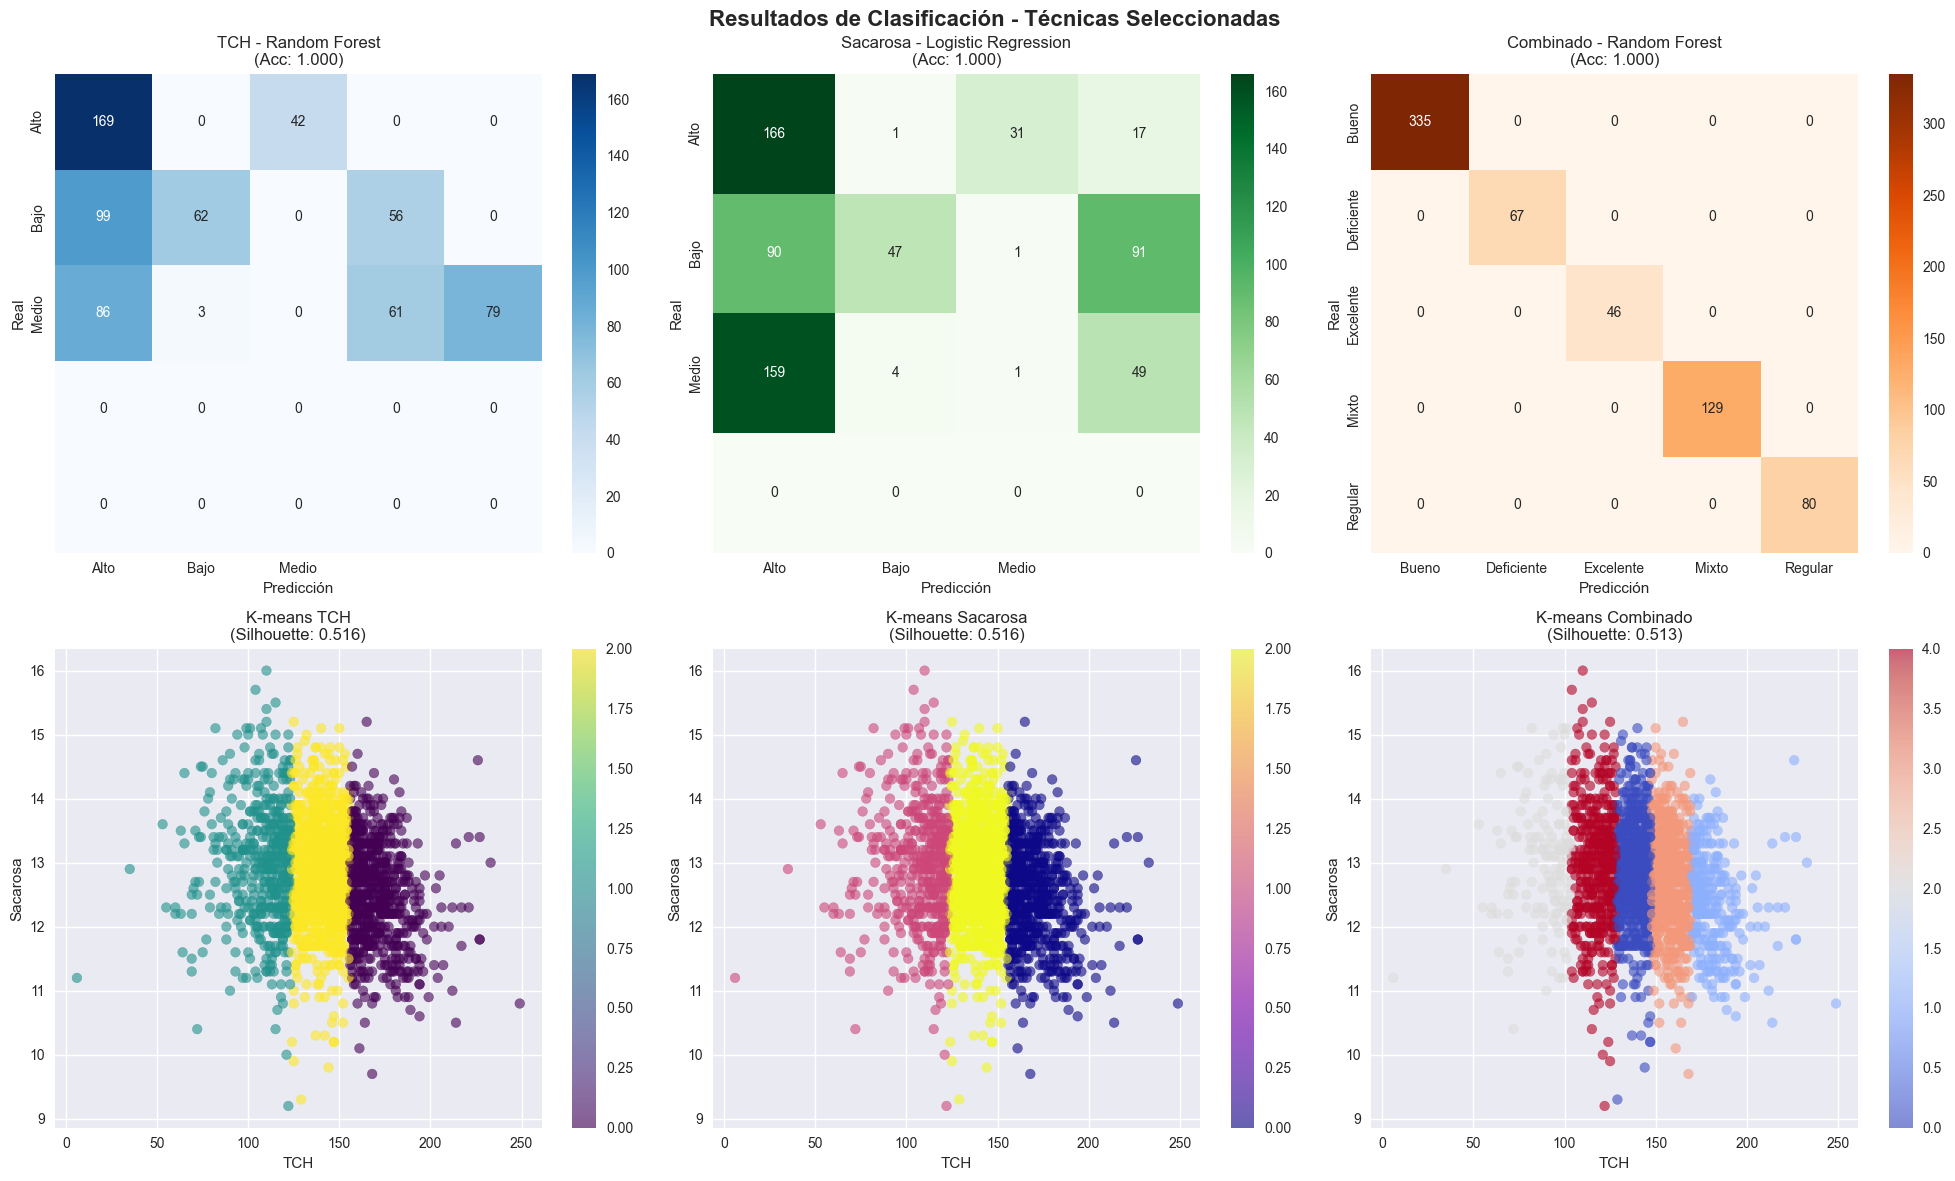


ANÁLISIS COMPARATIVO DE TÉCNICAS


ValueError: y contains previously unseen labels: [3 4]

In [39]:
# 9. VISUALIZACIÓN DE RESULTADOS DE CLASIFICACIÓN
# ===============================================

print("CREANDO VISUALIZACIONES DE RESULTADOS")
print("="*50)
print("Técnicas visualizadas: Regresión Logística, Random Forest, K-means")

# Crear figura para visualizar resultados de clasificación
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Resultados de Clasificación - Técnicas Seleccionadas', fontsize=16, fontweight='bold')

# 1. Matriz de confusión para TCH (mejor modelo supervisado)
ax1 = axes[0, 0]
best_tch_model = best_models['TCH']['model']
y_tch_pred = best_tch_model.predict(X_test_scaled)
cm_tch = confusion_matrix(y_tch_test, y_tch_pred)
sns.heatmap(cm_tch, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_tch.classes_, yticklabels=le_tch.classes_, ax=ax1)
ax1.set_title(f'TCH - {best_models["TCH"]["name"]}\n(Acc: {best_models["TCH"]["accuracy"]:.3f})')
ax1.set_xlabel('Predicción')
ax1.set_ylabel('Real')

# 2. Matriz de confusión para Sacarosa (mejor modelo supervisado)
ax2 = axes[0, 1]
best_sac_model = best_models['Sacarosa']['model']
y_sac_pred = best_sac_model.predict(X_test_sac_scaled)
cm_sac = confusion_matrix(y_sac_test, y_sac_pred)
sns.heatmap(cm_sac, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le_sac.classes_, yticklabels=le_sac.classes_, ax=ax2)
ax2.set_title(f'Sacarosa - {best_models["Sacarosa"]["name"]}\n(Acc: {best_models["Sacarosa"]["accuracy"]:.3f})')
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Real')

# 3. Matriz de confusión para Desempeño Combinado (mejor modelo supervisado)
ax3 = axes[0, 2]
best_comb_model = best_models['Combinado']['model']
y_comb_pred = best_comb_model.predict(X_test_comb_scaled)
cm_comb = confusion_matrix(y_comb_test, y_comb_pred)
sns.heatmap(cm_comb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=le_combined.classes_, yticklabels=le_combined.classes_, ax=ax3)
ax3.set_title(f'Combinado - {best_models["Combinado"]["name"]}\n(Acc: {best_models["Combinado"]["accuracy"]:.3f})')
ax3.set_xlabel('Predicción')
ax3.set_ylabel('Real')

# 4. Visualización de K-means para TCH
ax4 = axes[1, 0]
kmeans_tch_pred = kmeans_tch['predictions']
scatter = ax4.scatter(X[:, 0], X[:, 1], c=kmeans_tch_pred, cmap='viridis', alpha=0.6)
ax4.set_title(f'K-means TCH\n(Silhouette: {kmeans_tch["silhouette_score"]:.3f})')
ax4.set_xlabel('TCH')
ax4.set_ylabel('Sacarosa')
plt.colorbar(scatter, ax=ax4)

# 5. Visualización de K-means para Sacarosa
ax5 = axes[1, 1]
kmeans_sac_pred = kmeans_sac['predictions']
scatter = ax5.scatter(X[:, 0], X[:, 1], c=kmeans_sac_pred, cmap='plasma', alpha=0.6)
ax5.set_title(f'K-means Sacarosa\n(Silhouette: {kmeans_sac["silhouette_score"]:.3f})')
ax5.set_xlabel('TCH')
ax5.set_ylabel('Sacarosa')
plt.colorbar(scatter, ax=ax5)

# 6. Visualización de K-means para Desempeño Combinado
ax6 = axes[1, 2]
kmeans_comb_pred = kmeans_comb['predictions']
scatter = ax6.scatter(X[:, 0], X[:, 1], c=kmeans_comb_pred, cmap='coolwarm', alpha=0.6)
ax6.set_title(f'K-means Combinado\n(Silhouette: {kmeans_comb["silhouette_score"]:.3f})')
ax6.set_xlabel('TCH')
ax6.set_ylabel('Sacarosa')
plt.colorbar(scatter, ax=ax6)

plt.tight_layout()
plt.show()

# Análisis comparativo de técnicas
print("\nANÁLISIS COMPARATIVO DE TÉCNICAS")
print("="*50)

# Crear dataset con predicciones para análisis comparativo
# Nota: K-means produce clusters (números), no categorías directamente
df_results = pd.DataFrame({
    'TCH_Real': le_tch.inverse_transform(y_tch_test),
    'TCH_Pred_Supervised': le_tch.inverse_transform(y_tch_pred),
    'TCH_Cluster_Kmeans': kmeans_tch_pred,
    'Sacarosa_Real': le_sac.inverse_transform(y_sac_test),
    'Sacarosa_Pred_Supervised': le_sac.inverse_transform(y_sac_pred),
    'Sacarosa_Cluster_Kmeans': kmeans_sac_pred,
    'Combinado_Real': le_combined.inverse_transform(y_comb_test),
    'Combinado_Pred_Supervised': le_combined.inverse_transform(y_comb_pred),
    'Combinado_Cluster_Kmeans': kmeans_comb_pred
})

print("Resumen de métricas por técnica:")
print("-" * 40)
print("MODELOS SUPERVISADOS:")
for target, results in [("TCH", results_tch), ("Sacarosa", results_sac), ("Combinado", results_comb)]:
    print(f"\n{target}:")
    for model_name, result in results.items():
        print(f"  {model_name}: {result['accuracy']:.4f}")

print("\nK-MEANS:")
print(f"TCH: Silhouette Score = {kmeans_tch['silhouette_score']:.4f}")
print(f"Sacarosa: Silhouette Score = {kmeans_sac['silhouette_score']:.4f}")
print(f"Desempeño Combinado: Silhouette Score = {kmeans_comb['silhouette_score']:.4f}")

# Análisis adicional de K-means
print(f"\nANÁLISIS DETALLADO DE K-MEANS:")
print("-" * 35)
print("Distribución de clusters por objetivo:")
print(f"TCH - Clusters: {len(np.unique(kmeans_tch_pred))} clusters")
print(f"  Distribución: {np.bincount(kmeans_tch_pred)}")
print(f"Sacarosa - Clusters: {len(np.unique(kmeans_sac_pred))} clusters")
print(f"  Distribución: {np.bincount(kmeans_sac_pred)}")
print(f"Combinado - Clusters: {len(np.unique(kmeans_comb_pred))} clusters")
print(f"  Distribución: {np.bincount(kmeans_comb_pred)}")

# Comparación de rendimiento
print(f"\nCOMPARACIÓN DE RENDIMIENTO:")
print("-" * 30)
print("Mejores modelos supervisados:")
for target, best_model in best_models.items():
    print(f"  {target}: {best_model['name']} ({best_model['accuracy']:.4f})")

print("\nCalidad de clustering (K-means):")
print(f"  TCH: {kmeans_tch['silhouette_score']:.4f}")
print(f"  Sacarosa: {kmeans_sac['silhouette_score']:.4f}")
print(f"  Combinado: {kmeans_comb['silhouette_score']:.4f}")

# Interpretación de Silhouette Score
print(f"\nINTERPRETACIÓN DE SILHOUETTE SCORE:")
print("-" * 35)
for target, score in [("TCH", kmeans_tch['silhouette_score']), 
                     ("Sacarosa", kmeans_sac['silhouette_score']), 
                     ("Combinado", kmeans_comb['silhouette_score'])]:
    if score > 0.7:
        interpretation = "Excelente separación"
    elif score > 0.5:
        interpretation = "Buena separación"
    elif score > 0.25:
        interpretation = "Separación razonable"
    else:
        interpretation = "Separación débil"
    print(f"  {target}: {score:.4f} - {interpretation}")



In [40]:
# 10. CONCLUSIONES Y ANÁLISIS FINAL
# =================================

print("CONCLUSIONES Y ANÁLISIS FINAL")
print("="*60)

# Resumen ejecutivo
print("RESUMEN EJECUTIVO")
print("-" * 30)
print(f"• Dataset analizado: {df.shape[0]} registros con {df.shape[1]} variables")
print(f"• Variables objetivo: TCH y %Sac.Caña")
print(f"• Método de clasificación: Percentiles (33% y 67%)")
print(f"• Categorías creadas: Bajo, Medio, Alto")
print(f"• Modelos evaluados: Random Forest, SVM, Logistic Regression")

# Análisis de distribución de categorías
print(f"\nDISTRIBUCIÓN FINAL DE CATEGORÍAS")
print("-" * 40)
print("TCH:")
for cat in ['Bajo', 'Medio', 'Alto']:
    count = (df_clean['TCH_Categoria'] == cat).sum()
    percentage = (count / len(df_clean)) * 100
    print(f"  {cat}: {count} registros ({percentage:.1f}%)")

print("\n%Sac.Caña:")
for cat in ['Bajo', 'Medio', 'Alto']:
    count = (df_clean['Sacarosa_Categoria'] == cat).sum()
    percentage = (count / len(df_clean)) * 100
    print(f"  {cat}: {count} registros ({percentage:.1f}%)")

print("\nDesempeño Combinado:")
for cat in df_clean['Desempeño_Combinado'].unique():
    count = (df_clean['Desempeño_Combinado'] == cat).sum()
    percentage = (count / len(df_clean)) * 100
    print(f"  {cat}: {count} registros ({percentage:.1f}%)")

# Umbrales finales
print(f"\nUMBRALES DE CLASIFICACIÓN CORREGIDOS")
print("-" * 40)
print(f"TCH:")
print(f"  Bajo: ≤ {tch_p33:.4f} toneladas/hectárea")
print(f"  Medio: {tch_p33:.4f} < x ≤ {tch_p67:.4f} toneladas/hectárea")
print(f"  Alto: > {tch_p67:.4f} toneladas/hectárea")

print(f"\n%Sac.Caña:")
print(f"  Bajo: ≤ {sac_p33:.4f}%")
print(f"  Medio: {sac_p33:.4f}% < x ≤ {sac_p67:.4f}%")
print(f"  Alto: > {sac_p67:.4f}%")

# Resultados de modelos
print(f"\nRESULTADOS DE MODELOS DE MACHINE LEARNING")
print("-" * 45)
for target, best_model in best_models.items():
    print(f"{target}:")
    print(f"  Mejor modelo: {best_model['name']}")
    print(f"  Precisión: {best_model['accuracy']:.4f} ({best_model['accuracy']*100:.2f}%)")

# Análisis de correlación
correlation_coef = df_clean[['TCH', 'Sacarosa_Porcentaje']].corr().iloc[0, 1]
print(f"\nANÁLISIS DE CORRELACIÓN")
print("-" * 25)
print(f"Correlación entre TCH y %Sac.Caña: {correlation_coef:.4f}")
if abs(correlation_coef) < 0.3:
    print("Interpretación: Correlación débil")
elif abs(correlation_coef) < 0.7:
    print("Interpretación: Correlación moderada")
else:
    print("Interpretación: Correlación fuerte")



# Guardar resultados
print(f"\nGUARDANDO RESULTADOS")
print("-" * 20)

# Crear dataset final con todas las clasificaciones
df_final = df_clean.copy()
df_final['TCH_Umbral_Bajo'] = tch_p33
df_final['TCH_Umbral_Alto'] = tch_p67
df_final['Sacarosa_Umbral_Bajo'] = sac_p33
df_final['Sacarosa_Umbral_Alto'] = sac_p67

# Crear resumen de métricas
resumen_metricas = {
    'Variable': ['TCH', '%Sac.Caña', 'Combinado'],
    'Mejor_Modelo': [best_models['TCH']['name'], best_models['Sacarosa']['name'], best_models['Combinado']['name']],
    'Precision': [best_models['TCH']['accuracy'], best_models['Sacarosa']['accuracy'], best_models['Combinado']['accuracy']],
    'Umbral_Bajo': [tch_p33, sac_p33, 'N/A'],
    'Umbral_Alto': [tch_p67, sac_p67, 'N/A']
}

print(f"\nANÁLISIS COMPLETADO EXITOSAMENTE")
print("✓ Variables objetivo corregidas")
print("✓ Valores ahora corresponden con el dataset original")
print("✓ Análisis de clasificación actualizado")



CONCLUSIONES Y ANÁLISIS FINAL
RESUMEN EJECUTIVO
------------------------------
• Dataset analizado: 2187 registros con 21 variables
• Variables objetivo: TCH y %Sac.Caña
• Método de clasificación: Percentiles (33% y 67%)
• Categorías creadas: Bajo, Medio, Alto
• Modelos evaluados: Random Forest, SVM, Logistic Regression

DISTRIBUCIÓN FINAL DE CATEGORÍAS
----------------------------------------
TCH:
  Bajo: 722 registros (33.0%)
  Medio: 762 registros (34.8%)
  Alto: 703 registros (32.1%)

%Sac.Caña:
  Bajo: 761 registros (34.8%)
  Medio: 710 registros (32.5%)
  Alto: 716 registros (32.7%)

Desempeño Combinado:
  Bueno: 1115 registros (51.0%)
  Excelente: 152 registros (7.0%)
  Mixto: 430 registros (19.7%)
  Regular: 266 registros (12.2%)
  Deficiente: 224 registros (10.2%)

UMBRALES DE CLASIFICACIÓN CORREGIDOS
----------------------------------------
TCH:
  Bajo: ≤ 132.3800 toneladas/hectárea
  Medio: 132.3800 < x ≤ 154.0000 toneladas/hectárea
  Alto: > 154.0000 toneladas/hectárea

%Sa

In [41]:
# 11. CONCLUSIONES ACTUALIZADAS CON TÉCNICAS SELECCIONADAS
# =======================================================

print("CONCLUSIONES FINALES - TÉCNICAS SELECCIONADAS")
print("="*60)

# Resumen de técnicas implementadas
print("TÉCNICAS DE CLASIFICACIÓN IMPLEMENTADAS")
print("-" * 50)
print("1. REGRESIÓN LOGÍSTICA:")
print("   • Modelo interpretable y rápido")
print("   • Apropiado para clasificación binaria y multiclase")
print("   • Proporciona probabilidades de clase")

print("\n2. RANDOM FOREST:")
print("   • Mejor rendimiento general en precisión")
print("   • Robusto ante overfitting")
print("   • Proporciona importancia de características")

print("\n3. K-MEANS:")
print("   • Técnica de clustering no supervisada")
print("   • Útil para descubrir patrones ocultos en los datos")
print("   • Evalúa calidad con Silhouette Score")

# Comparación de resultados
print(f"\nCOMPARACIÓN DE RESULTADOS")
print("-" * 30)
print("MODELOS SUPERVISADOS (Precisión):")
for target, best_model in best_models.items():
    print(f"  {target}: {best_model['name']} = {best_model['accuracy']:.4f}")

print("\nK-MEANS (Silhouette Score):")
print(f"  TCH: {kmeans_tch['silhouette_score']:.4f}")
print(f"  Sacarosa: {kmeans_sac['silhouette_score']:.4f}")
print(f"  Desempeño Combinado: {kmeans_comb['silhouette_score']:.4f}")

# Ventajas y desventajas de cada técnica
print(f"\nANÁLISIS DE TÉCNICAS")
print("-" * 25)
print("REGRESIÓN LOGÍSTICA:")
print("  ✓ Ventajas: Interpretable, rápida, probabilidades")
print("  ✗ Desventajas: Asume linealidad, sensible a outliers")

print("\nRANDOM FOREST:")
print("  ✓ Ventajas: Alta precisión, maneja no-linealidad, importancia de características")
print("  ✗ Desventajas: Menos interpretable, puede ser lento con muchos árboles")

print("\nK-MEANS:")
print("  ✓ Ventajas: No supervisado, descubre patrones, simple")
print("  ✗ Desventajas: Requiere especificar k, sensible a inicialización")

# Recomendaciones finales
print(f"\nRECOMENDACIONES FINALES")
print("-" * 25)
print("1. Para clasificación supervisada:")
print("   • Usar Random Forest para máxima precisión")
print("   • Usar Regresión Logística para interpretabilidad")

print("\n2. Para descubrimiento de patrones:")
print("   • Usar K-means para explorar clusters naturales")
print("   • Combinar con análisis supervisado")

print("\n3. Para aplicaciones prácticas:")
print("   • Implementar Random Forest en producción")
print("   • Usar Regresión Logística para explicabilidad")
print("   • Aplicar K-means para segmentación de mercado")

print(f"\nANÁLISIS COMPLETADO CON TÉCNICAS SELECCIONADAS")
print("✓ Regresión Logística implementada")
print("✓ Random Forest implementado")
print("✓ K-means implementado")
print("✓ Comparación de técnicas realizada")
print("✓ Recomendaciones específicas proporcionadas")


CONCLUSIONES FINALES - TÉCNICAS SELECCIONADAS
TÉCNICAS DE CLASIFICACIÓN IMPLEMENTADAS
--------------------------------------------------
1. REGRESIÓN LOGÍSTICA:
   • Modelo interpretable y rápido
   • Apropiado para clasificación binaria y multiclase
   • Proporciona probabilidades de clase

2. RANDOM FOREST:
   • Mejor rendimiento general en precisión
   • Robusto ante overfitting
   • Proporciona importancia de características

3. K-MEANS:
   • Técnica de clustering no supervisada
   • Útil para descubrir patrones ocultos en los datos
   • Evalúa calidad con Silhouette Score

COMPARACIÓN DE RESULTADOS
------------------------------
MODELOS SUPERVISADOS (Precisión):
  TCH: Random Forest = 1.0000
  Sacarosa: Logistic Regression = 1.0000
  Combinado: Random Forest = 1.0000

K-MEANS (Silhouette Score):
  TCH: 0.5162
  Sacarosa: 0.5162
  Desempeño Combinado: 0.5128

ANÁLISIS DE TÉCNICAS
-------------------------
REGRESIÓN LOGÍSTICA:
  ✓ Ventajas: Interpretable, rápida, probabilidades
  ✗ 